# 1. Preparación de Entorno. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from pmdarima import auto_arima
%pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import ruptures as rpt
from sklearn.preprocessing import StandardScaler

Note: you may need to restart the kernel to use updated packages.


# 2. Carga de Datos. 

## Acuíferos. 

In [2]:
# Load the aquifer hydrology data
df_aquifers = pd.read_csv("../data/processed/aquifers/aquifer_hydrology_data_clean.csv")
df_aquifers.head()

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_60741/7009082.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_aquifers = pd.read_csv("../data/processed/aquifers/aquifer_hydrology_data_clean.csv")


,Date,was_nan,Value,Medition_Types,Location
0,1999-01-01,1,0.0,1,1
1,2000-01-01,1,0.0,1,1
2,2001-01-01,1,0.0,1,1
3,2002-01-01,1,0.0,1,1
4,2003-01-01,1,0.0,1,1


## Lagos. 

In [3]:
# Load the lake hydrology data
df_lakes = pd.read_csv("../data/processed/lakes/lake_hydrology_data_clean.csv")
df_lakes.head()

,Date,Value,Measurement_Types,Location
0,2002-06-03,0.0,1,1
1,2002-06-04,0.0,1,1
2,2002-06-05,0.0,1,1
3,2002-06-06,0.0,1,1
4,2002-06-07,0.0,1,1


## Ríos. 

In [4]:
# Load the river hydrology data
df_rivers = pd.read_csv("../data/processed/rivers/river_hydrology_data_clean.csv")
df_rivers.head()

,Date,Value,Measurement_Types,Location
0,1998-01-01,0.0,1,1
1,1998-01-02,0.0,1,1
2,1998-01-03,0.0,1,1
3,1998-01-04,0.0,1,1
4,1998-01-05,0.0,1,1


## Manantiales. 

In [5]:
# Load the water spring hydrology data
df_water_spring = pd.read_csv("../data/processed/water_spring/water_spring_hydrology_data_clean.csv")
df_water_spring.head()

,Date,Value,Measurement_Types,Location
0,2000-01-01,0.0,1,1
1,2001-01-01,0.0,1,1
2,2002-01-01,0.0,1,1
3,2003-01-01,0.0,1,1
4,2004-01-01,0.0,1,1


# 3. Definir Features (X) y Variable Target (Y). 

Para definir las variables features y la variable target, se considerarán los datos que nos son útiles para visualizar el nivel de agua según la fecha de cada cuerpo de agua, en este caso __"Value"__ es la variable target, mientras que el resto de las variables se considerarán variables feature.

# 4. Dividir data en train y test. 

In [6]:
import pandas as pd

def split_time_series_by_percentage(df, split_percentage):
    """
    Splits a time series DataFrame into training and testing sets
    based on a specified percentage. The DataFrame must be ordered chronologically.

    Args:
        df (pd.DataFrame): The input time series DataFrame.
        split_percentage (float): The percentage of data to use for the training set (e.g., 0.8 for 80%).

    Returns:
        tuple: A tuple containing the training and testing DataFrames (train_df, test_df).
    """
    if not 0 < split_percentage < 1:
        raise ValueError("split_percentage must be between 0 and 1.")

    split_point = int(len(df) * split_percentage)
    
    train_df = df.iloc[:split_point]
    test_df = df.iloc[split_point:]
    
    return train_df, test_df

# Example usage:
# Assuming 'df' is your time series DataFrame, already sorted by date.
# train_data, test_data = split_time_series_by_percentage(df, 0.8)

# print("Train Data:")
# print(train_data)
# print("\nTest Data:")
# print(test_data)

In [7]:
# Split the aquifer data into training and testing sets
train_data_aquifers, test_data_aquifers = split_time_series_by_percentage(df_aquifers, 0.8)

In [8]:
# Split the lakes data into training and testing sets
train_data_lakes, test_data_lakes = split_time_series_by_percentage(df_lakes, 0.8)

In [9]:
# Split the rivers data into training and testing sets
train_data_rivers, test_data_rivers = split_time_series_by_percentage(df_rivers, 0.8)

In [10]:
# Split the water_spring data into training and testing sets
train_data_water_spring, test_data_water_spring = split_time_series_by_percentage(df_water_spring, 0.8)

# 5. Análisis de Series de Tiempo. 

In [11]:
train_data_aquifers['Date'] = pd.to_datetime(train_data_aquifers['Date'], errors='coerce')

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_60741/2953720666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_aquifers['Date'] = pd.to_datetime(train_data_aquifers['Date'], errors='coerce')


In [12]:
train_data_aquifers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273974 entries, 0 to 273973
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            8154 non-null    datetime64[ns]
 1   was_nan         273974 non-null  int64         
 2   Value           273974 non-null  float64       
 3   Medition_Types  273974 non-null  int64         
 4   Location        273974 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 10.5 MB


In [13]:
train_data_aquifers['Date'] = train_data_aquifers['Date'].dt.date

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_60741/383748217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_aquifers['Date'] = train_data_aquifers['Date'].dt.date


In [14]:
all_data = train_data_aquifers.set_index('Date')

In [15]:
ts = all_data["Value"]

In [16]:
ts.head()

Date
1999-01-01    0.0
2000-01-01    0.0
2001-01-01    0.0
2002-01-01    0.0
2003-01-01    0.0
Name: Value, dtype: float64

Punto de quiebre detectado en el índice: 610, fecha: 2014-10-15 00:00:00
Punto de quiebre detectado en el índice: 620, fecha: 2015-01-11 00:00:00
Punto de quiebre detectado en el índice: 800, fecha: 2020-01-25 00:00:00
Punto de quiebre detectado en el índice: 805, fecha: 2020-03-13 00:00:00


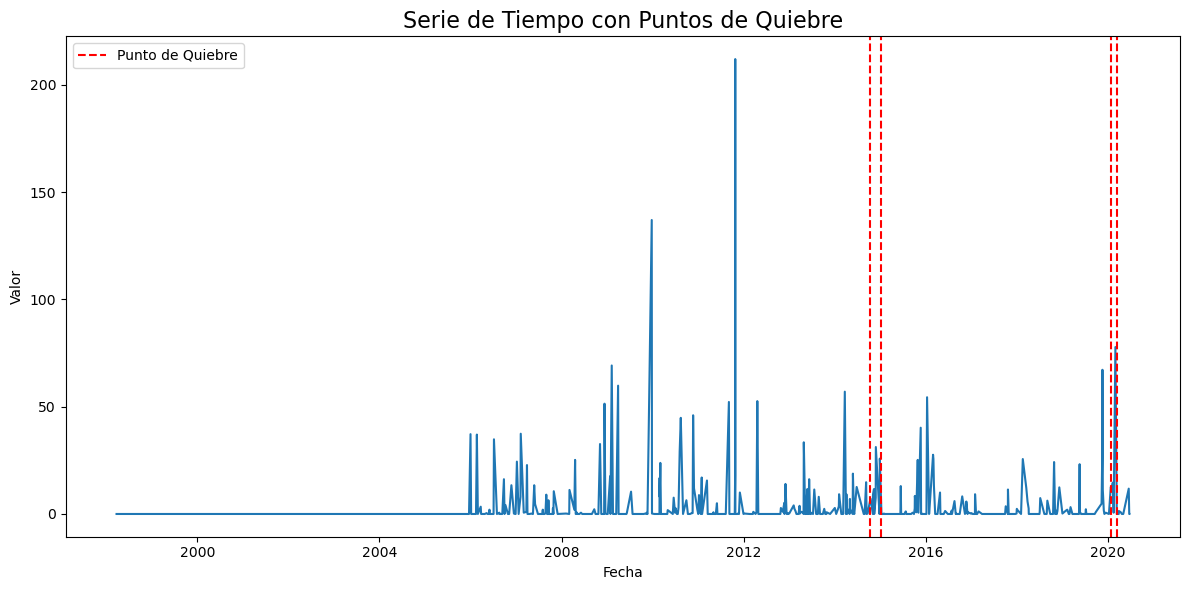

In [17]:

# Reemplaza 'train_data_aquifers' con tu DataFrame real
# y 'Date' y 'Value' con los nombres de tus columnas si son diferentes.
# df = pd.read_csv('tu_archivo.csv') # Ejemplo para cargar tus datos
df = train_data_aquifers.copy()

# Paso 1: Limpieza y preparación del DataFrame.
# Asegúrate de que la columna de fechas esté en el formato correcto
df['Date'] = pd.to_datetime(df['Date'])
# Elimina filas con valores de fecha no válidos (NaT)
df.dropna(subset=['Date'], inplace=True)
# Ordena el DataFrame por la columna de fechas
df.sort_values(by='Date', inplace=True)
# Establece la columna de fechas como el índice
df.set_index('Date', inplace=True)

# Paso 2: Muestreo y limpieza de valores nulos o infinitos.
# Esto es para que el kernel no se bloquee con datos grandes
sample_size = 0.1  # 10% de tus datos
df_sampled = df.sample(frac=sample_size, random_state=42)
# Reordena el DataFrame después del muestreo para el gráfico
df_sampled.sort_index(inplace=True)
# Limpia los datos de la muestra antes de la detección
df_sampled = df_sampled.replace([np.inf, -np.inf], np.nan).dropna()

# Paso 3: Escalar los datos para la detección de quiebres.
values_original = df_sampled['Value'].values.reshape(-1, 1)
scaler = StandardScaler()
values_scaled = scaler.fit_transform(values_original)

# Paso 4: Detección de puntos de quiebre.
# Usa BinSeg, que es más rápido y robusto para datos grandes.
# Aquí le decimos que busque 1 punto de quiebre. Puedes ajustar este valor. 
algo = rpt.Pelt(model="l1").fit(values_scaled)
result = algo.predict(pen=1)

# Paso 5: Graficar la serie de tiempo con los puntos de quiebre.
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_sampled.index, values_original)
ax.set_title('Serie de Tiempo con Puntos de Quiebre', fontsize=16)
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')

for cp in result[:-1]:
    ax.axvline(x=df_sampled.index[cp], color='red', linestyle='--', label='Punto de Quiebre' if cp == result[0] else "")
    print(f"Punto de quiebre detectado en el índice: {cp}, fecha: {df_sampled.index[cp]}")

plt.legend()
plt.tight_layout()
plt.show()

/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


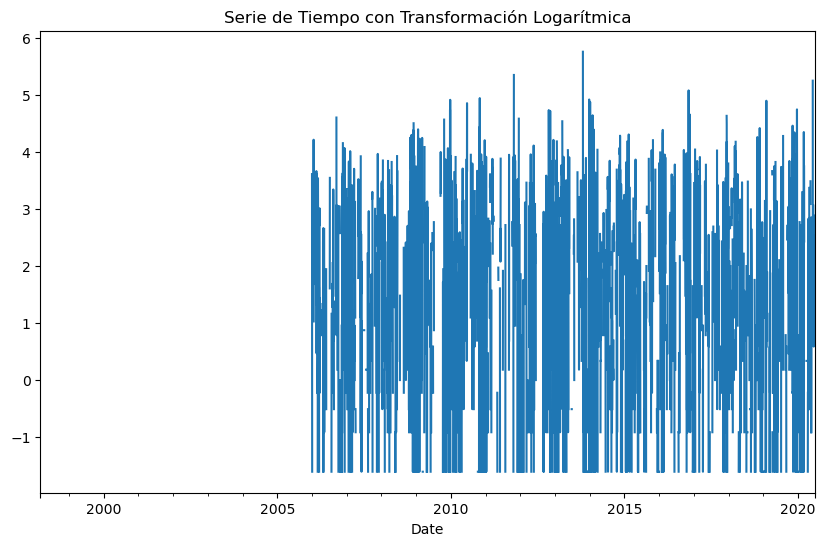

In [18]:
# --- 2. Estabilizar la Varianza (Transformación Logarítmica) ---
df['log_value'] = np.log(df['Value'])
df['log_value'].plot(title='Serie de Tiempo con Transformación Logarítmica', figsize=(10, 6))
plt.show()

In [19]:
df['log_value'].unique()

array([       -inf,  3.61630876,  1.16315081, -1.60943791,  1.68639895,
        4.21950771,  1.02961942,  2.39789527,  3.48431229,  2.8678989 ,
        2.10413415,  0.58778666,  1.33500107,  3.66867675,  3.03495299,
        0.47000363,  2.19722458,  3.17805383,  3.61091791,  2.37954613,
        1.64865863, -0.22314355,  0.        ,  2.99573227,  3.20274644,
        3.54385368,  3.0155349 ,  0.69314718,  1.88706965,  1.60943791,
        2.72129543,  1.22377543,  1.43508453, -0.51082562,  0.78845736,
        0.95551145,  2.41591378, -0.91629073,  2.66722821,  2.02814825,
        2.65324196,  2.43361336,  1.94591015,  1.48160454,  1.7227666 ,
        3.54961739,  1.56861592,  1.28093385,  2.05412373,  2.89037176,
        3.34638915,  3.15273602,  1.38629436,  1.85629799,  4.60916221,
        3.06339092,  0.18232156,  2.78501124,  3.05400118,  3.04452244,
        2.73436751,  2.58021683,  2.8094027 ,  3.56671182,  3.6323091 ,
        4.15888308,  2.59525471,  3.09104245,  3.64283552,  1.09

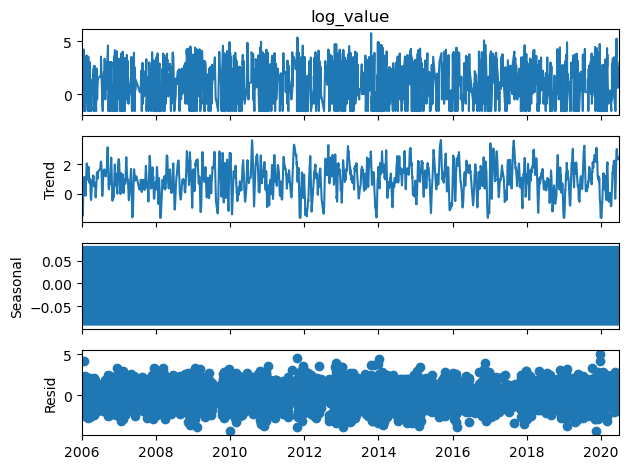

In [23]:
# 1. Aplicar la transformación logarítmica

# 2. Reemplazar los valores infinitos con NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Eliminar o rellenar los valores NaN
# Opción A: Eliminar las filas con NaN
df_cleaned = df.dropna(subset=['log_value'])

# Opción B: Rellenar con interpolación lineal
#df['log_value'].interpolate(method='linear', inplace=True)

# 4. Ahora puedes ejecutar la descomposición en el DataFrame limpio
# Usando la Opción A:
decomposition = seasonal_decompose(df_cleaned['log_value'], model='additive', period=12)

# O usando la Opción B:
#decomposition = seasonal_decompose(df['log_value'], model='additive', period=12)

decomposition.plot()
plt.show()

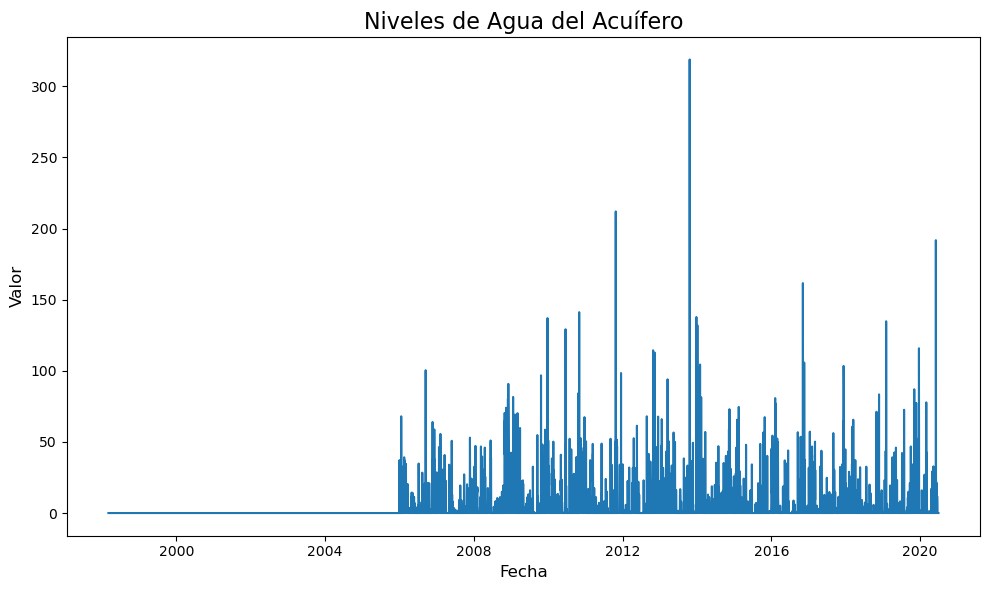

In [ ]:
# --- Código mejorado para la gráfica ---
fig, axis = plt.subplots(figsize=(10, 6))

# Título de la gráfica
plt.title('Niveles de Agua del Acuífero', fontsize=16)

# Etiquetas de los ejes
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor', fontsize=12) # Considera cambiar 'Valor' por una unidad más específica

# Gráfica de la línea
sns.lineplot(data=ts, ax=axis)

# Ajustar el diseño para que todo quepa
plt.tight_layout()

# Mostrar la gráfica
plt.show()


In [ ]:
# Decompose the time series to analyze its components
decomposition = seasonal_decompose(ts, period = 12)
decomposition

### Análisis de tendencia.

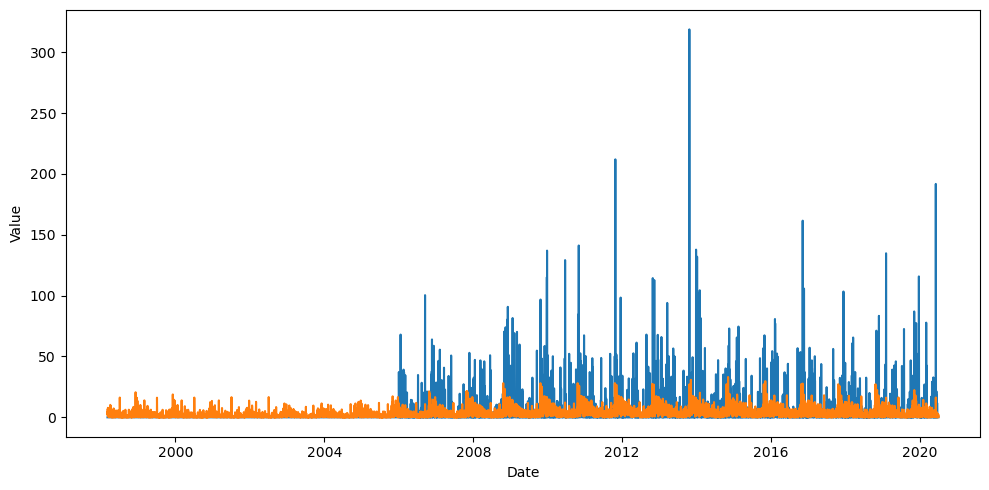

In [ ]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Conclusión (Análisis de tendencia):  
Podemos observar que la tendencia es congruente con la serie, es una tendencia creciente.

### Análisis de estacionalidad.

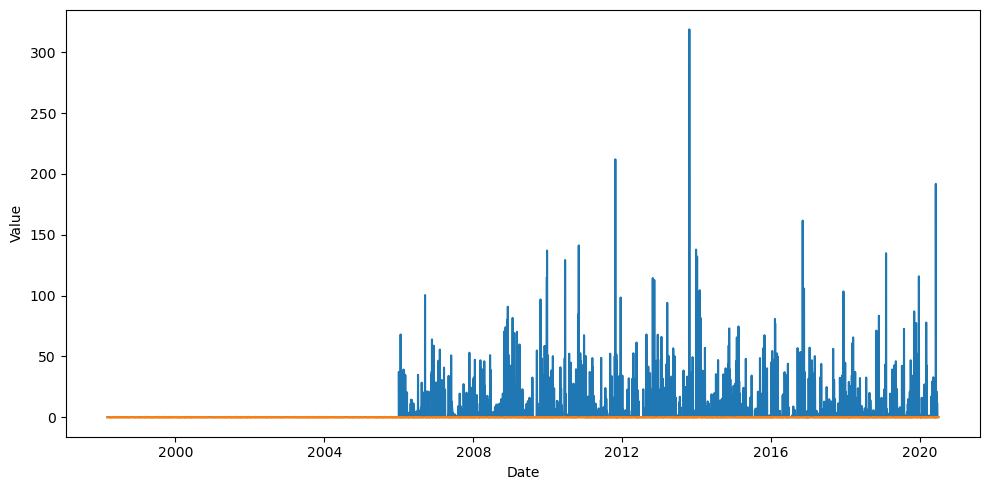

In [ ]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

### Prueba de Dickey-Fuller (Dickey-Fuller test).

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                    -22.038542
p-value                             0.000000
#Lags Used                         87.000000
Number of Observations Used    273886.000000
Critical Value (1%)                -3.430374
Critical Value (5%)                -2.861551
Critical Value (10%)               -2.566776
dtype: float64

### Análisis de variabilidad.

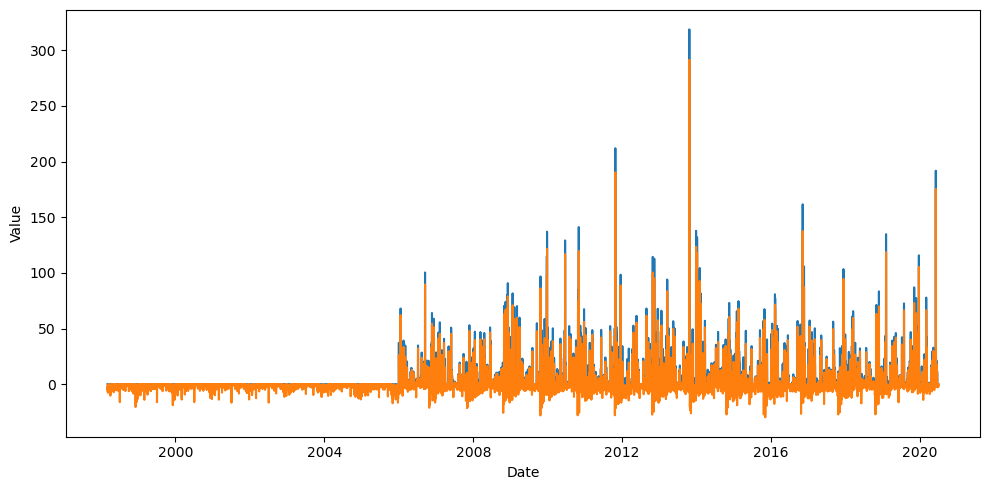

In [ ]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

### Análisis de autocorrelación.

In [ ]:
ts.head()

Date
1999-01-01    0.0
2000-01-01    0.0
2001-01-01    0.0
2002-01-01    0.0
2003-01-01    0.0
Name: Value, dtype: float64

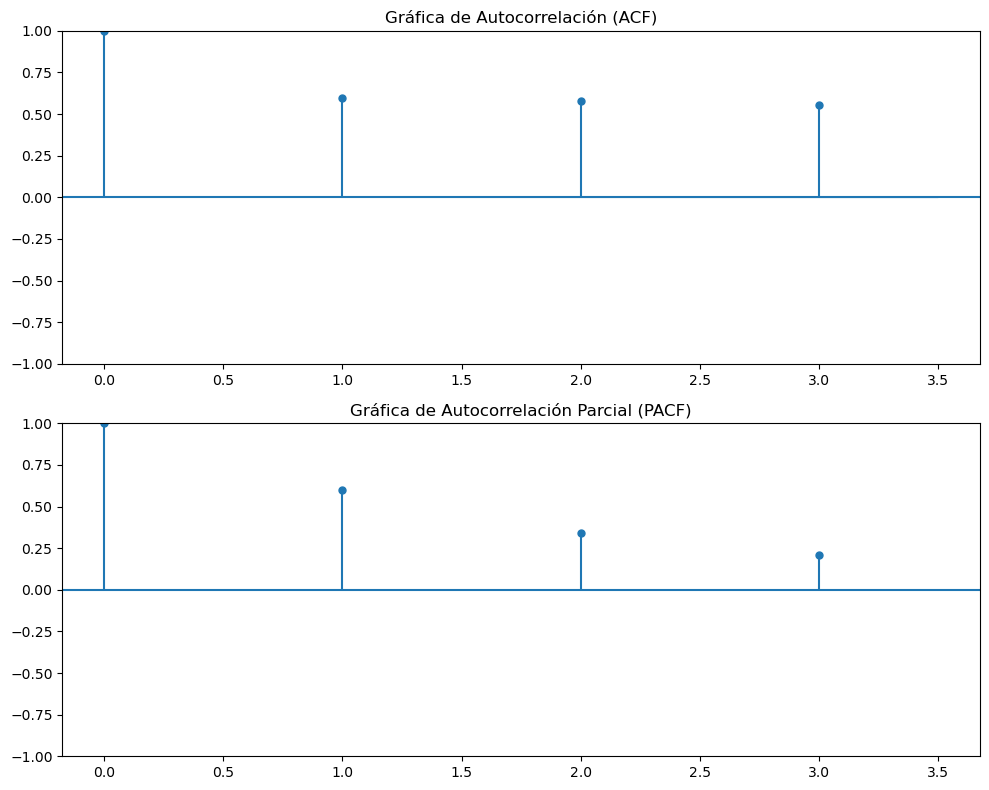

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Crear un DataFrame de ejemplo
# Asegúrate de que tu DataFrame ya sea estacionario
# data = {'fecha': pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05']),
#         'valor': [10, 12, 11, 15, 13]}
df_da = pd.DataFrame(train_data_aquifers).set_index('Date')

# 2. Generar y mostrar las gráficas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Gráfica de Autocorrelación (ACF)
plot_acf(df_da['Value'], ax=ax1, lags=3)
ax1.set_title('Gráfica de Autocorrelación (ACF)')

# Gráfica de Autocorrelación Parcial (PACF)
plot_pacf(df_da['Value'], ax=ax2, lags=3)
ax2.set_title('Gráfica de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

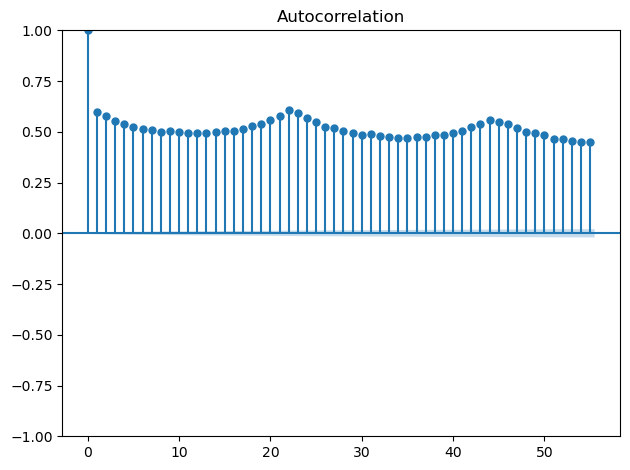

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()

plt.show()

# 6. Evaluar modelos e Hiperpárametros.

In [ ]:
test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


KeyboardInterrupt: 

In [ ]:
# Toma los últimos 500 o 1000 puntos de datos, por ejemplo
ts_sample = ts.tail(1000)

# Ejecuta auto_arima con la muestra
model = auto_arima(ts_sample, seasonal=True, m=12, trace=True)

/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/bereniceramos/miniconda3/envs/new_pmdarim

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5153.620, Time=2.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5566.137, Time=0.01 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5289.670, Time=0.62 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5369.792, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7557.802, Time=0.01 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=5159.032, Time=1.79 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=5126.641, Time=1.66 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=5217.374, Time=0.34 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=5100.360, Time=4.69 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=5151.374, Time=4.85 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=5225.759, Time=3.08 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=5231.689, Time=3.01 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,0)[12] intercept   : AIC=5173.105, Time=5.01 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(2,0,0)[12] intercept   : AIC=5160.393, Time=4.57 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=5231.318, Time=2.20 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(2,0,0)[12] intercept   : AIC=5166.037, Time=3.07 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,0,0)[12] intercept   : AIC=5189.525, Time=3.52 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(2,0,0)[12] intercept   : AIC=5161.957, Time=5.49 sec


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[12]             : AIC=inf, Time=3.11 sec

Best model:  ARIMA(2,0,2)(2,0,0)[12] intercept
Total fit time: 49.803 seconds


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1000
Model:             SARIMAX(2, 0, 2)x(2, 0, [], 12)   Log Likelihood               -2542.180
Date:                             Thu, 21 Aug 2025   AIC                           5100.360
Time:                                     14:30:53   BIC                           5139.622
Sample:                                          0   HQIC                          5115.283
                                            - 1000                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.4584      0.167    -20.756      0.000      -3.785      -3.132
ar.L1          1.6632      0.009    187.911      0.000       1.646       1.681
ar.L2         -0.9743      0.008   -125.327      0.000      -0.990      -0.959
ma.L1         -1.5796      0.011   -139.627      0.000      -1.602      -1.557
ma.L2          0.9537      0.011     85.441      0.000       0.932       0.976
ar.S.L12      -0.3096      0.040     -7.655      0.000      -0.389      -0.230
ar.S.L24       0.1793      0.032      5.573      0.000       0.116       0.242
sigma2         9.3833      0.692     13.552      0.000       8.026      10.740
===================================================================================
Ljung-Box (L1) (Q):                   4.57   Jarque-Bera (JB):                17.39
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.09
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast = model.predict(n_periods=10)
forecast

/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1000   -10.791359
1001    -9.262112
1002   -10.701580
1003    -9.709555
1004    -9.729385
1005    -8.151259
1006    -9.953622
1007    -8.359332
1008    -9.685228
1009   -11.801406
dtype: float64

In [ ]:
test_stationarity(forecast)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -2.772808
p-value                        0.062264
#Lags Used                     0.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64

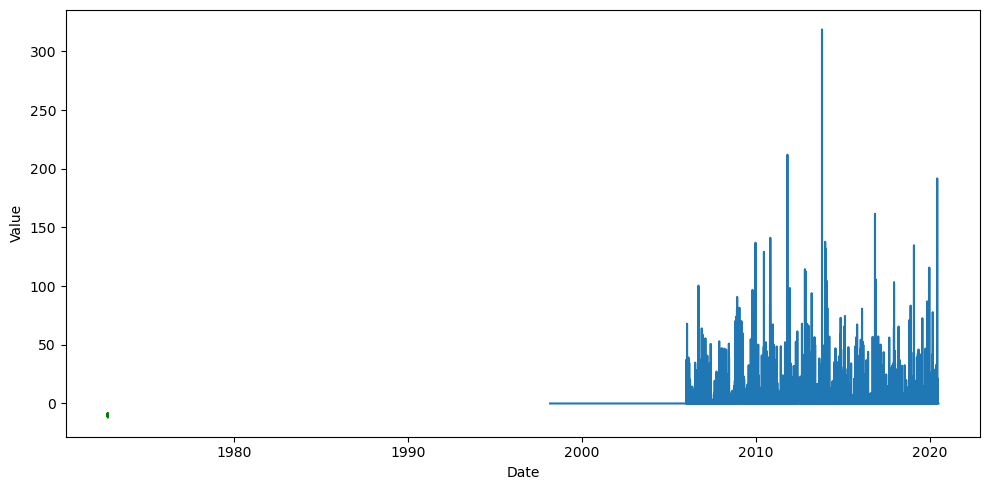

In [ ]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Entrenar el modelo ARIMA con 'train_data'
# Asumimos que los parámetros (p, d, q) son 1, 1, 1
model = ARIMA(train_data_aquifers['Value'], order=(0, 1, 1))
fitted_model = model.fit()

print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:               273974
Model:                 ARIMA(0, 1, 1)   Log Likelihood             -918480.079
Date:                Thu, 21 Aug 2025   AIC                        1836964.159
Time:                        14:33:54   BIC                        1836985.200
Sample:                             0   HQIC                       1836970.268
                             - 273974                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9273      0.000  -1856.077      0.000      -0.928      -0.926
sigma2        47.7991      0.017   2741.205      0.000      47.765      47.833
Ljung-Box (L1) (Q):                4036.66   Jarque-

MSE en el conjunto de prueba: 133506414.10803159


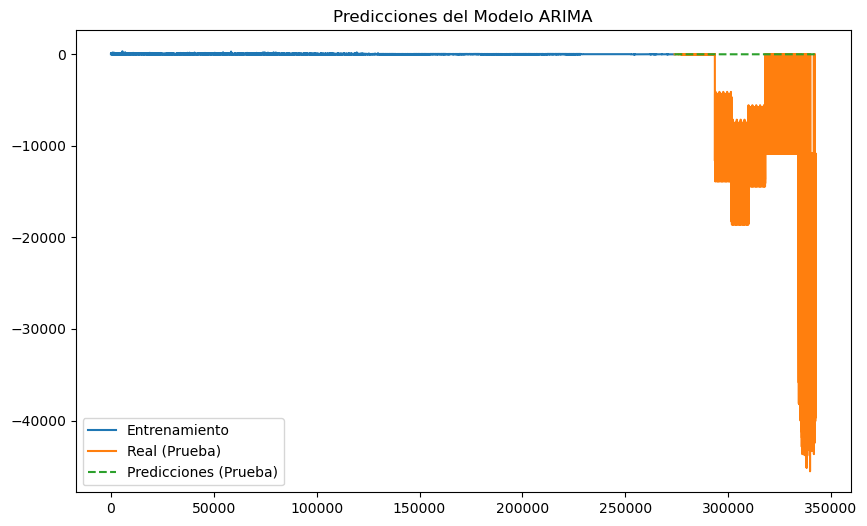

In [ ]:
from sklearn.metrics import mean_squared_error

# Hacer predicciones en el conjunto de prueba
# `len(test_data_aquifers)` especifica cuántos pasos hacia el futuro se deben predecir
predictions = fitted_model.forecast(steps=len(test_data_aquifers))

# Evaluar el rendimiento del modelo con el Error Cuadrático Medio (MSE)
mse = mean_squared_error(test_data_aquifers['Value'], predictions)
print(f"MSE en el conjunto de prueba: {mse}")

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(train_data_aquifers.index, train_data_aquifers['Value'], label='Entrenamiento')
plt.plot(test_data_aquifers.index, test_data_aquifers['Value'], label='Real (Prueba)')
plt.plot(test_data_aquifers.index, predictions, label='Predicciones (Prueba)', linestyle='--')
plt.title('Predicciones del Modelo ARIMA')
plt.legend()
plt.show()

# 7. Guardar Modelos. 